# 4차 프로그래밍 과제

IV. 4차 프로그래밍과제 구현 내용

(1) II. 데이터 셋에서 주어진 특징들을 선택하여 CPU 성능 즉, “PRP” 변수를 예측하는 Pipeline 기반 다중 회귀 모델링을 프로그래밍 하시오.
- 데이터 탐색 및 시각화, 전처리, 훈련 데이터와 테스트 데이터 분리, 하이퍼파라미터 튜닝, 훈련 데이터 앙상블 학습 과정, 교차 검증, 분석 결과 시각화 등을 포함하여 최적화하는 전체 과정을 포함하시오.

(2) (1) 단계에서 얻은 Pipeline 기반 모델 GridSearchCV의 best_estimator모델을 사용하여 학습 데이터와 테스트 데이터 각각에 대해 이 모델의 성능을 평가하시오.
- Mean squared Error, Mean absolute Error, R^2, 교차검증

(3) (2) 단계에서 얻은 Pipeline 기반 GridSearchCV의 best_estimator모델의 테스트 데이터에 대해 예측 성능 R^2가 85% 이상이 나오도록 모델을 개선하시오.
앙상블을 쓴다던가 피쳐엔지니어링을쓴다던가 하기.

(4) I. 3차 프로그래밍 과제의 기본모델의 (2) 단계와 II. 4차 프로그래밍 과제의 제안 모델의 (2) 단계에서 얻은 학습 데이터와 테스트 데이터에 대한 성능 지표(MSE, MAE, R^2, 교차 검증)를 데이터프레임에 저장하여 이 성능 결과를 바 차트로 시각화하여 학습 데이터와 테스트 데이터에 대한 각 모델의 성능 차이를 비교 분석하시오.
예시)

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import missingno as msn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor

1. 데이터 로드

In [41]:
# 데이터 불러오기
machine = pd.read_csv('machine.data_update.csv')

machine.head()

,VendorName,ModelName,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


2. feature engineering : 중요 특징 추출

PRP                    1.000000
ERP                    0.966472
MMAX                   0.863004
MMIN                   0.794931
CACH                   0.662641
                         ...   
model_v8655            0.002430
model_as/6650          0.002324
model_50-850-ii        0.001460
model_as/7000-n        0.000269
model_cyber:170/835    0.000163
Name: PRP, Length: 247, dtype: float64


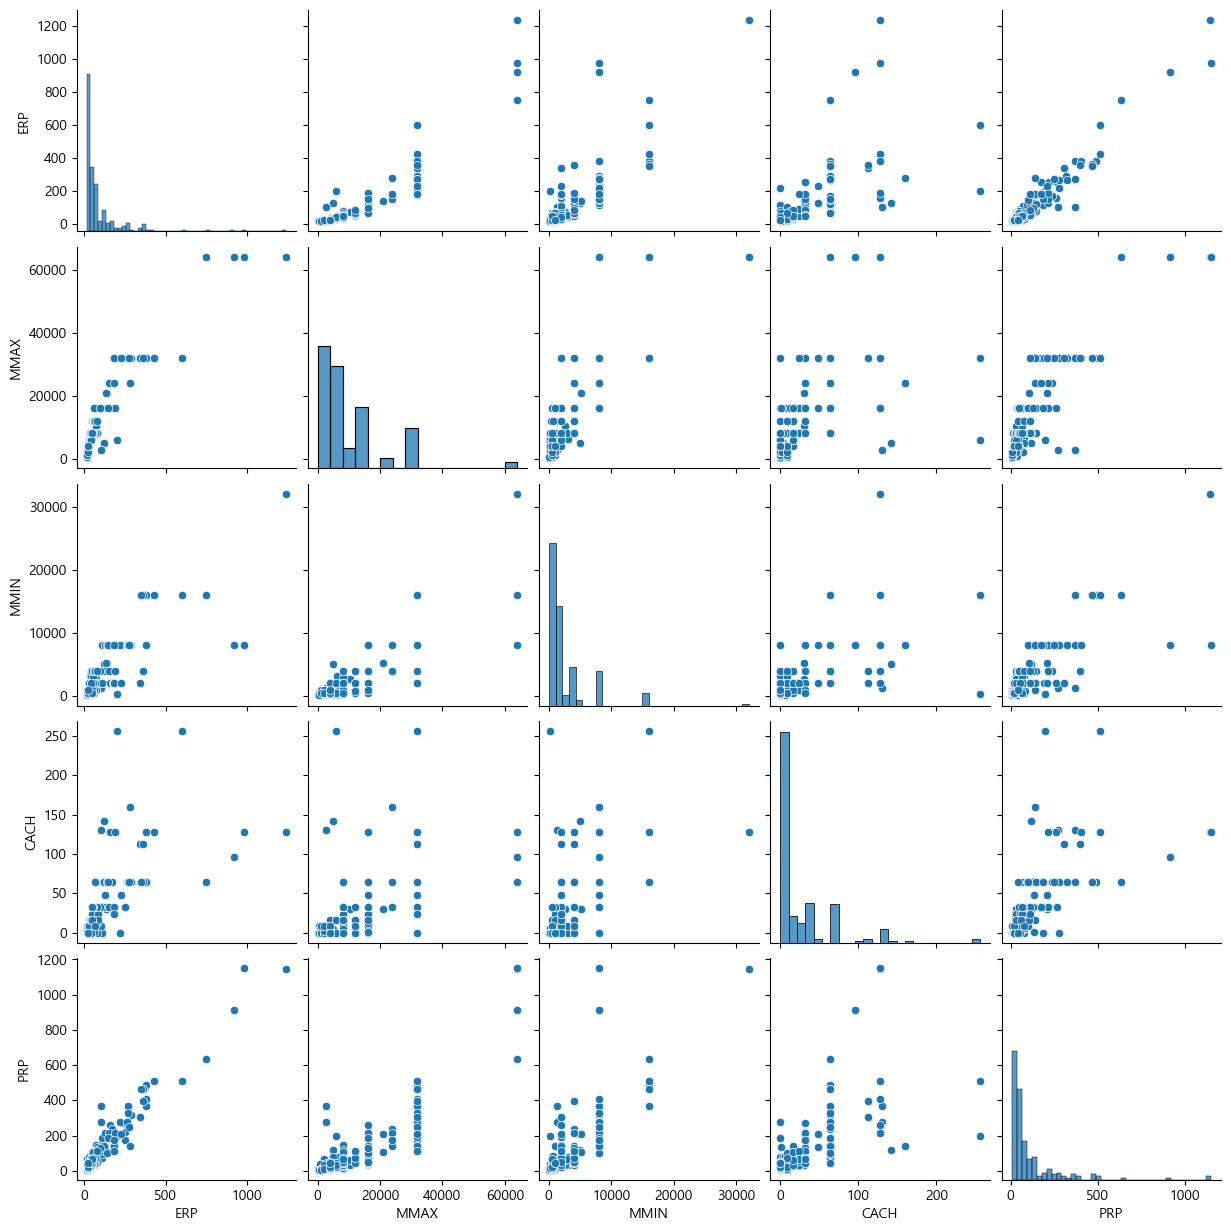

In [42]:
# 범주형 데이터 수치화
dum_vendor = pd.get_dummies(machine['VendorName'], prefix='vendor', dtype=float)
dum_model = pd.get_dummies(machine['ModelName'], prefix='model', dtype=float)
machine = pd.concat([machine.drop(['VendorName', 'ModelName'], axis=1), dum_vendor, dum_model], axis=1)

# (1) PRP에 관련된 다른 특성들과의 상관계수 값만을 출력
result = machine.corr()['PRP']

# 상관계수 값을 양의 상관계수로 처리
result = np.abs(result)

# 상관계수를 내림차순으로 정렬하기
result_sorted = result.sort_values(ascending=False)
print(result_sorted)

# 선택할 features 설정 (상관계수가 높은 상위 4개 특성)
features = result_sorted.index[1:5].tolist()  # PRP 제외
features.append('PRP')

# 상관계수가 높은 4개의 특성에 대한 pairplot 그리기
sns.pairplot(machine[features])
plt.show()

In [62]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features[:-1])  # PRP 제외
    ])

2)데이터 스케일링

In [52]:
# X와 y 설정
X = machine[features]
y = machine['PRP']

In [53]:
# X & y 차원 구하기
X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [54]:
# 개별 모델 정의
models = [ ('lr', LinearRegression()), ('sgd', SGDRegressor(  )) ]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators = models)


# 파이프라인 생성
model_pipeline = Pipeline(steps =  [
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
    ])

# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter': [1000, 2000, 3000]
}


In [55]:
grid_search = GridSearchCV(model_pipeline, param_grid,
                           cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ERP',
                                                                          'MMAX',
                                                                          'MMIN',
                                                                          'CACH'])])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor())]))]),
             param_grid={'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
                         'ensemble__sgd__max_iter': [1000, 2000, 3000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [56]:
# 최적 파라미터 출력
print(f"Best parameters found : {grid_search.best_params_}")

# 최적 모델로 예측
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred.shape
y_pred[:10]

Best parameters found : {'ensemble__sgd__alpha': 0.0001, 'ensemble__sgd__max_iter': 1000}


array([ 127.11490129,   30.02656833,   30.02656833,  952.50885924,
         35.91051151,  276.90270183,   44.77043778,   26.59467106,
       1312.14267584,  228.79620784])

In [57]:
# 훈련 데이터 예측
y_train_pred = best_model.predict(X_train)

print("훈련 데이터 성능:")
print(f"MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"R^2: {r2_score(y_train, y_train_pred)}")

# 테스트 데이터 예측
y_test_pred = best_model.predict(X_test)

print("\n테스트 데이터 성능:")
print(f"MSE: {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred)}")
print(f"R^2: {r2_score(y_test, y_test_pred)}")

# 교차 검증 예측
cv_scores_mse = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_mae = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

print("\n교차 검증 성능:")
print(f"MSE mean: {cv_scores_mse.mean()}")
print(f"MAE mean: {cv_scores_mae.mean()}")
print(f"R^2 mean: {cv_scores_r2.mean()}")

훈련 데이터 성능:
MSE: 1628.0615824979743
MAE: 23.72022249470075
R^2: 0.9153129739667082

테스트 데이터 성능:
MSE: 1965.6552137937563
MAE: 28.43756253997338
R^2: 0.9613872181992503

교차 검증 성능:
MSE mean: 2345.37726606484
MAE mean: 26.24862006311404
R^2 mean: 0.8632603534270189


Text(0, 0.5, 'y_pred')

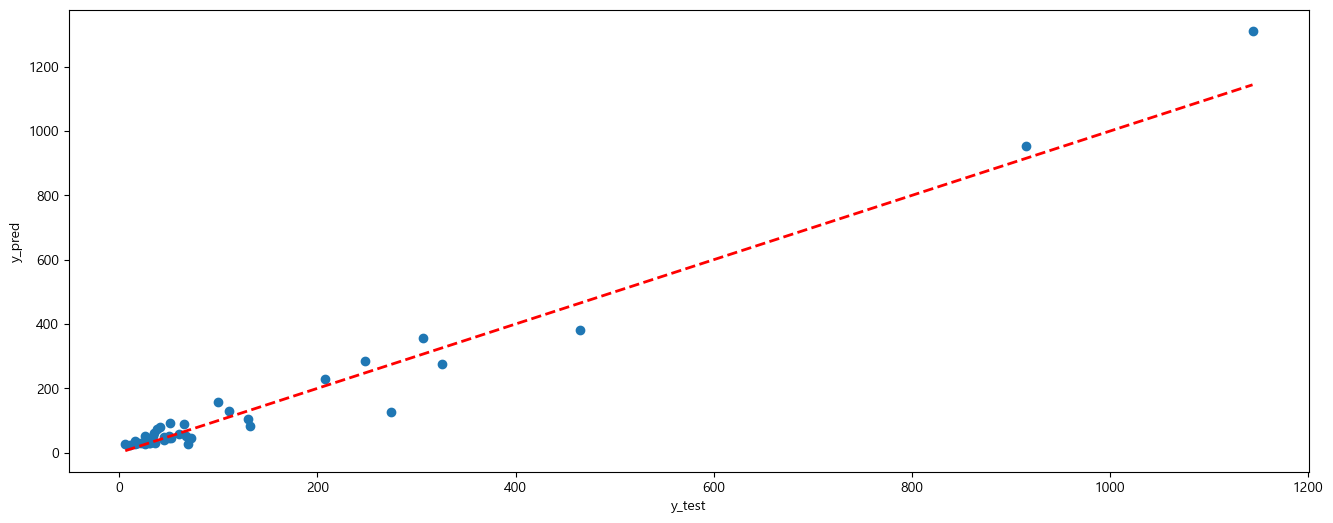

In [58]:
# 시각화
plt.figure(figsize = (16, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw =2 )
plt.xlabel('y_test')
plt.ylabel('y_pred')

In [59]:
# 성능 지표 저장
performance = {
    'model': ['Best_estimator', 'Best_estimator', 'Best_estimator'],
    'data': ['Train', 'Test', 'CrossValidation'],
    'mse': [1626.595283325392, 1995.075994588389, 2400.7051890292482],
    'mae': [23.75374938439722, 28.561505735370847, 26.327669341786464],
    'R^2': [0.9153892465828892, 0.9608092846017104, 0.8609231154663114]
}

# 데이터프레임 생성
performance_df4 = pd.DataFrame(performance)

# 데이터프레임을 CSV 파일로 저장
performance_df4.to_csv('performance_results4.csv', index=False)

performance_df4


,model,data,mse,mae,R^2
0,Best_estimator,Train,1626.595283,23.753749,0.915389
1,Best_estimator,Test,1995.075995,28.561506,0.960809
2,Best_estimator,CrossValidation,2400.705189,26.327669,0.860923


In [60]:
#3차 프로그래밍 결과와 4차 프로그래밍 결과 csv 파일 합치기
performance_lr = pd.read_csv('performance_results3.csv')
performance_be = pd.read_csv('performance_results4.csv')

# 두 데이터프레임 병합
merged_performance = pd.concat([performance_lr, performance_be], ignore_index=True)

# 병합된 데이터프레임을 새로운 CSV 파일로 저장
merged_performance.to_csv('merged_performance_results.csv', index=False)

merged_performance

,model,data,mse,mae,R^2
0,Linear Regression,Train,1626.595283,23.753749,0.915389
1,Linear Regression,Test,1995.075995,28.561506,0.960809
2,Linear Regression,CrossValidation,2400.705189,26.327669,0.860923
3,Best_estimator,Train,1626.595283,23.753749,0.915389
4,Best_estimator,Test,1995.075995,28.561506,0.960809
5,Best_estimator,CrossValidation,2400.705189,26.327669,0.860923


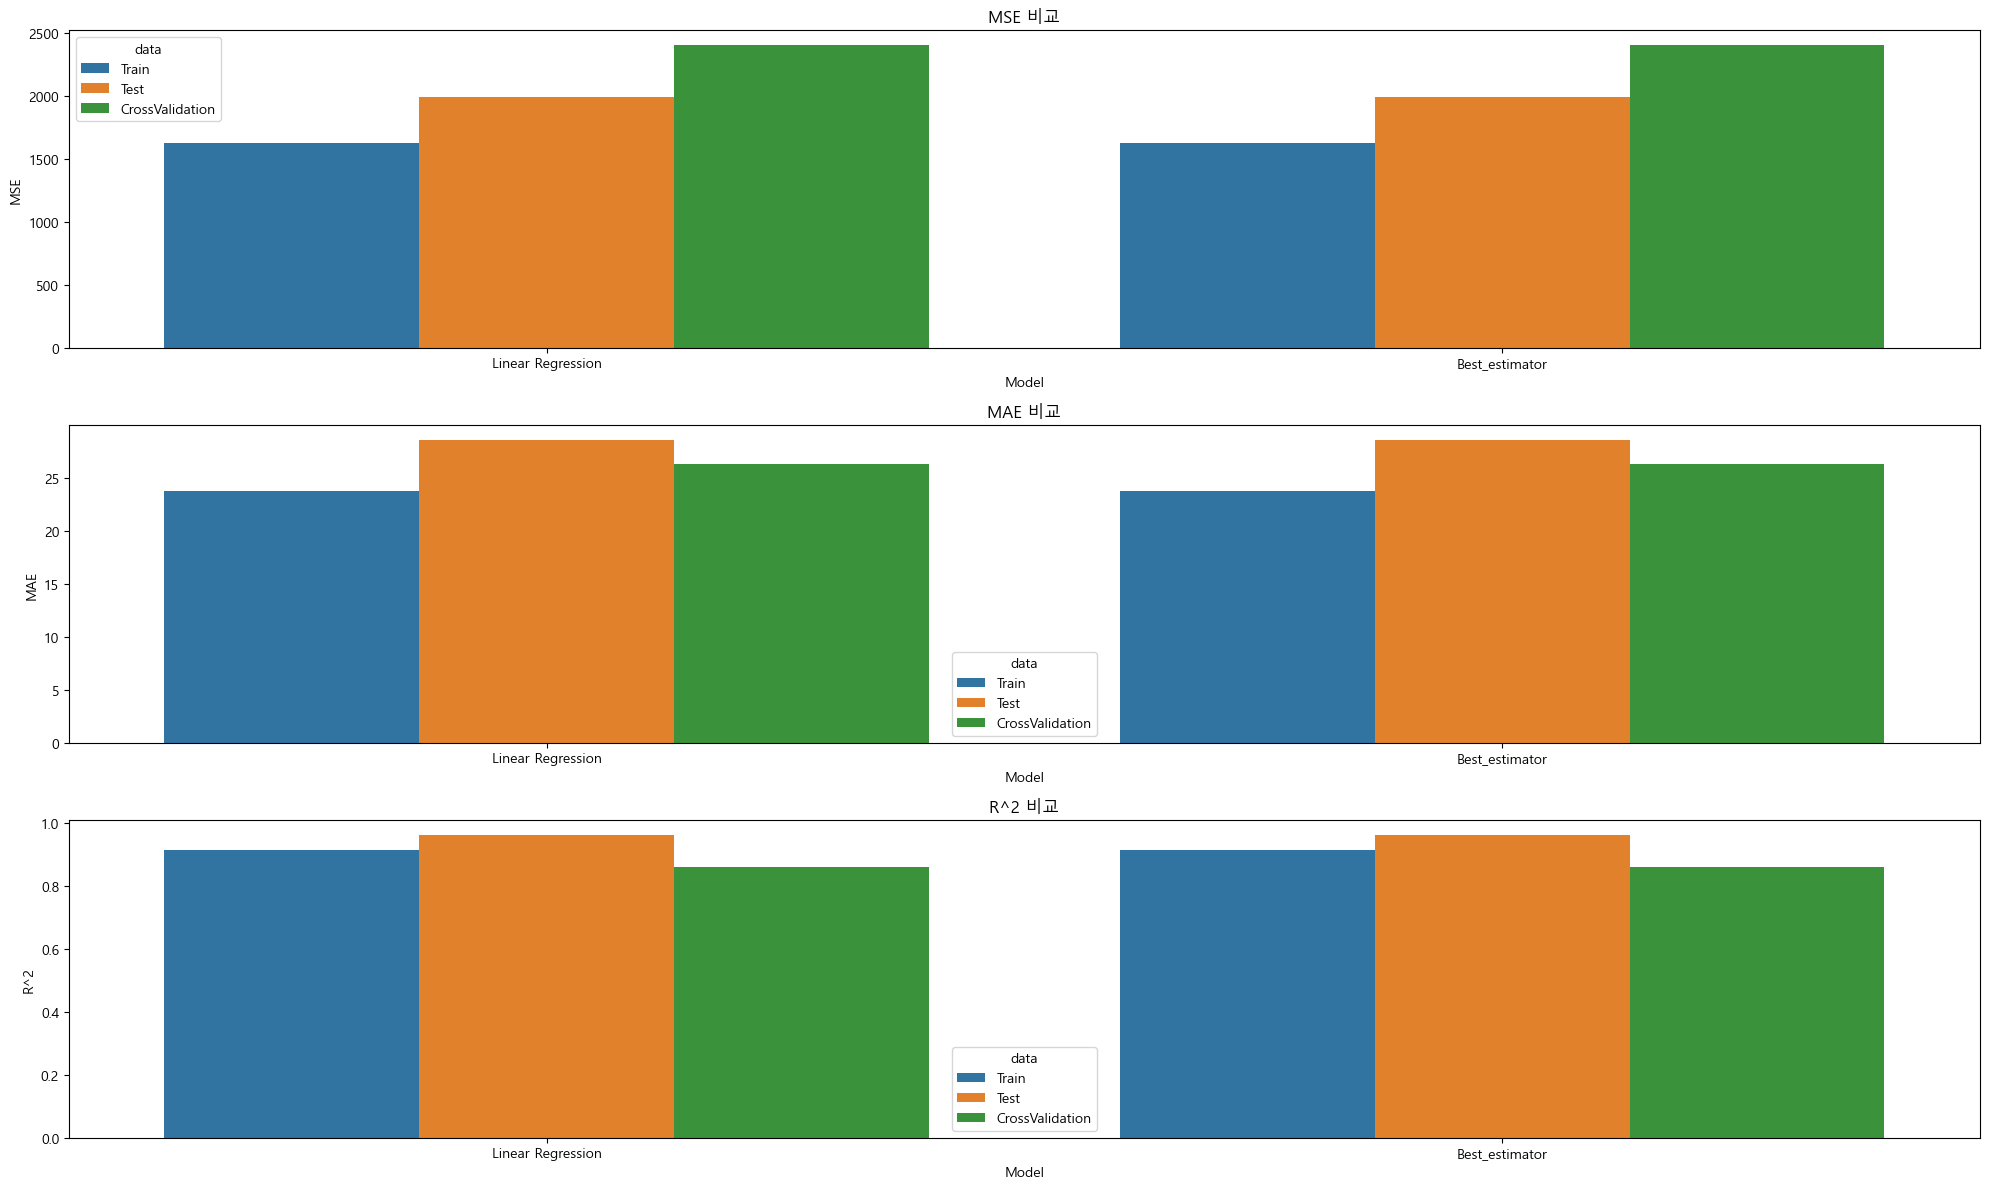

In [61]:
plt.rc('figure', figsize=(10, 6))
plt.rcParams["font.family"] = 'Malgun Gothic'

# 시각화 설정
plt.figure(figsize=(20, 12))

# MSE 비교
plt.subplot(3, 1, 1)
sns.barplot(x='model', y='mse', hue='data', data=merged_performance)
plt.title('MSE 비교')
plt.ylabel('MSE')
plt.xlabel('Model')

# MAE 비교
plt.subplot(3, 1, 2)
sns.barplot(x='model', y='mae', hue='data', data=merged_performance)
plt.title('MAE 비교')
plt.ylabel('MAE')
plt.xlabel('Model')

# R^2 비교
plt.subplot(3, 1, 3)
sns.barplot(x='model', y='R^2', hue='data', data=merged_performance)
plt.title('R^2 비교')
plt.ylabel('R^2')
plt.xlabel('Model')

# 차트 보여주기
plt.tight_layout()
plt.show()